In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from datetime import datetime 
pd.options.mode.chained_assignment = 'warn'  # default='warn'

In [2]:
scaler = StandardScaler(with_std=True, with_mean=True)

def filter_pca_data(df: pd.DataFrame, dropped_depths: list[int] = []):
    dropped_features = [
        'Unnamed: 0',
        'TIMESTAMP',
        'RECORD',
        'TIMESTAMP_DIFF',
        'Redox_error_flag_available',
        'log_redox(1)',
        'log_redox(2)',
        'log_redox(3)',
        'log_redox(4)',
        'log_redox(5)',
        'neg_log(1)',
        'neg_log(2)',
        'neg_log(3)',
        'neg_log(4)',
        'neg_log(5)',
        'Temp_T21_Avg(1)',
        'Temp_T21_Avg(2)',
        'Temp_T21_Avg(3)',
        'Temp_T21_Avg(4)',
        'Temp_T21_Avg(5)',
        'Redox_error_flag',
        'Redox_error_flag(1)',
        'Redox_error_flag(2)',
        'Redox_error_flag(3)',
        'Redox_error_flag(4)',
        'Redox_error_flag(5)',
        'CCVWC_Avg(1)',
        'CCVWC_Avg(2)',
        'CCVWC_Avg(3)',
        'CCVWC_Avg(4)',
        'CCVWC_Avg(5)',
        'shf_plate_Avg',
        'shf_multiplier',
        'shf_htr_resstnc',
        'shfp_wrnng_flg',
        'btt_wrnng_flg',
        'BatterymV_Min',
        'pit_number',
        # 'Redox_Avg(1)_sigma_b_12',
        # 'Redox_Avg(1)_sigma_f_12',
        # 'Redox_Avg(2)_sigma_b_12',
        # 'Redox_Avg(2)_sigma_f_12',
        # 'Redox_Avg(3)_sigma_b_12',
        # 'Redox_Avg(3)_sigma_f_12',
        # 'Redox_Avg(4)_sigma_b_12',
        # 'Redox_Avg(4)_sigma_f_12',
        # 'Redox_Avg(5)_sigma_b_12',
        # 'Redox_Avg(5)_sigma_f_12',
        # 'Redox_Avg(1)_sigma_b_24',
        # 'Redox_Avg(1)_sigma_f_24',
        # 'Redox_Avg(2)_sigma_b_24',
        # 'Redox_Avg(2)_sigma_f_24',
        # 'Redox_Avg(3)_sigma_b_24',
        # 'Redox_Avg(3)_sigma_f_24',
        # 'Redox_Avg(4)_sigma_b_24',
        # 'Redox_Avg(4)_sigma_f_24',
        # 'Redox_Avg(5)_sigma_b_24',
        # 'Redox_Avg(5)_sigma_f_24',
    ]
    for d in dropped_depths:
        dropped_features.extend([
            f'Redox_Avg({d})',
            f'EC_Avg({d})',
            f'Temp_T12_Avg({d})',
            f'Matric_potential_Avg({d})',
            f'WC{d}',
            f'Redox_Avg({d})_sigma_f'
            f'Redox_Avg({d})_sigma_b'
        ])
    pca_data = df.loc[:, ~df.columns.isin(dropped_features)]
    return pca_data

def get_pca_scores(pca_data, n_components):
    scaled = scaler.fit_transform(pca_data)
    pca = PCA(n_components)
    return pca.fit_transform(scaled)

def gmix(data, n_components, random_state):
    model = GaussianMixture(n_components=n_components, covariance_type='full', random_state=random_state).fit(data)
    scores = model.score_samples(data)
    return model.predict(data), scores

def pca_gmix(pca_data, full_data, n_clusters, n_components, outliers_fraction, random_state):
    pca_scores = get_pca_scores(pca_data, n_components)
    scaled_pca_scores = scaler.fit_transform(pca_scores)
    data = pd.DataFrame(scaled_pca_scores)

    clusters, scores = gmix(data, n_clusters, random_state)
    outlier_num = int(outliers_fraction * len(scores))
    idx = np.argpartition(scores, outlier_num)
    threshold = scores[idx[:outlier_num]].max()
    is_anomaly = (scores <= threshold)
    full_data = full_data.assign(cluster=clusters, anomaly=is_anomaly)
    return full_data

def get_acc_metric_dfs(df: pd.DataFrame):
    # true_positives = df.query('(`Redox_error_flag(1)` == True | `Redox_error_flag(2)` == True | `Redox_error_flag(3)` == True | `Redox_error_flag(4)` == True | `Redox_error_flag(5)` == True) & (anomaly == True)')
    # false_positives = df.query('(`Redox_error_flag(1)` == False & `Redox_error_flag(2)` == False & `Redox_error_flag(3)` == False & `Redox_error_flag(4)` == False & `Redox_error_flag(5)` == False) & (anomaly == True)')
    true_positives = df[((df['Redox_error_flag(1)'] == True) | (df['Redox_error_flag(2)'] == True) | (df['Redox_error_flag(3)'] == True) | (df['Redox_error_flag(4)'] == True) | (df['Redox_error_flag(5)'] == True)) & (df['anomaly'] == True)]
    false_positives = df[((df['Redox_error_flag(1)'] == False) & (df['Redox_error_flag(2)'] == False) & (df['Redox_error_flag(3)'] == False) & (df['Redox_error_flag(4)'] == False) & (df['Redox_error_flag(5)'] == False)) & (df['anomaly'] == True)]
    true_negatives = df[((df['Redox_error_flag(1)'] == False) & (df['Redox_error_flag(2)'] == False) & (df['Redox_error_flag(3)'] == False) & (df['Redox_error_flag(4)'] == False) & (df['Redox_error_flag(5)'] == False)) & (df['anomaly'] == False)]
    false_negatives = df[((df['Redox_error_flag(1)'] == True) | (df['Redox_error_flag(2)'] == True) | (df['Redox_error_flag(3)'] == True) | (df['Redox_error_flag(4)'] == True) | (df['Redox_error_flag(5)'] == True)) & (df['anomaly'] == False)]
    return (true_positives, true_negatives, false_positives, false_negatives)

def get_ind_depth_acc_metric_dfs(df: pd.DataFrame, pit: int):
    # true_positives = df.query('(`Redox_error_flag(1)` == True | `Redox_error_flag(2)` == True | `Redox_error_flag(3)` == True | `Redox_error_flag(4)` == True | `Redox_error_flag(5)` == True) & (anomaly == True)')
    # false_positives = df.query('(`Redox_error_flag(1)` == False & `Redox_error_flag(2)` == False & `Redox_error_flag(3)` == False & `Redox_error_flag(4)` == False & `Redox_error_flag(5)` == False) & (anomaly == True)')
    true_positives = df[(df[f'Redox_error_flag({pit})'] == True) & (df['anomaly'] == True)]
    false_positives = df[(df[f'Redox_error_flag({pit})'] == False) & (df['anomaly'] == True)]
    true_negatives = df[(df[f'Redox_error_flag({pit})'] == False) & (df['anomaly'] == False)]
    false_negatives = df[(df[f'Redox_error_flag({pit})'] == True) & (df['anomaly'] == False)]
    return (true_positives, true_negatives, false_positives, false_negatives)

def get_acc_metrics(acc_metric_dfs: tuple[pd.DataFrame]):
    true_positives, true_negatives, false_positives, false_negatives = acc_metric_dfs
    acc = (true_positives.shape[0] + true_negatives.shape[0]) / (true_positives.shape[0] + true_negatives.shape[0] + false_positives.shape[0] + false_negatives.shape[0])
    prec = true_positives.shape[0] / (true_positives.shape[0] + false_positives.shape[0])
    rec = true_positives.shape[0] / (true_positives.shape[0] + false_negatives.shape[0])
    return (acc, prec, rec)

# def compare_shifted(anomalys):
#     shifted = (anomalys.shift(-1) | anomalys.shift(1))
#     return (anomalys | shifted)

In [3]:
all_training_data = pd.read_csv('../../Data/Training/Raw_training_data_full.csv', parse_dates=['TIMESTAMP'])
training_data_2022 = all_training_data.loc[all_training_data['TIMESTAMP'] < datetime(2023, 1,1, 0, 0, 0), :]
training_data_2023 = all_training_data.loc[all_training_data['TIMESTAMP'] >= datetime(2023, 1,1, 0, 0, 0), :]

/tmp/ipykernel_8452/575840907.py:1: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  all_training_data = pd.read_csv('../../Data/Training/Raw_training_data_full.csv', parse_dates=['TIMESTAMP'])


## 2022 full data

Components: 5, clusters: 3, acc: 0.9101668794409208, precision: 0.8874011959584851, recall: 0.8720567375886524


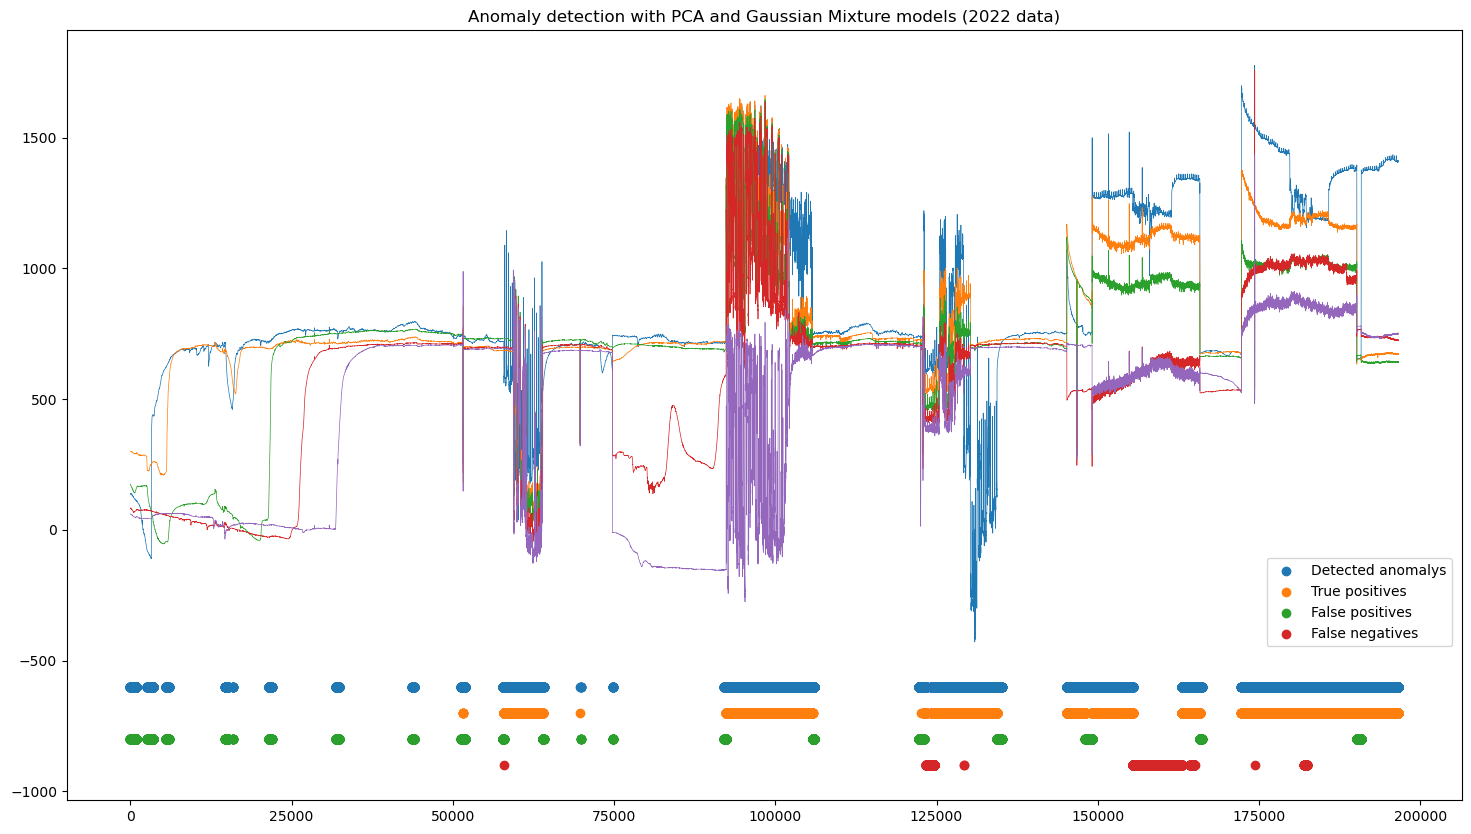

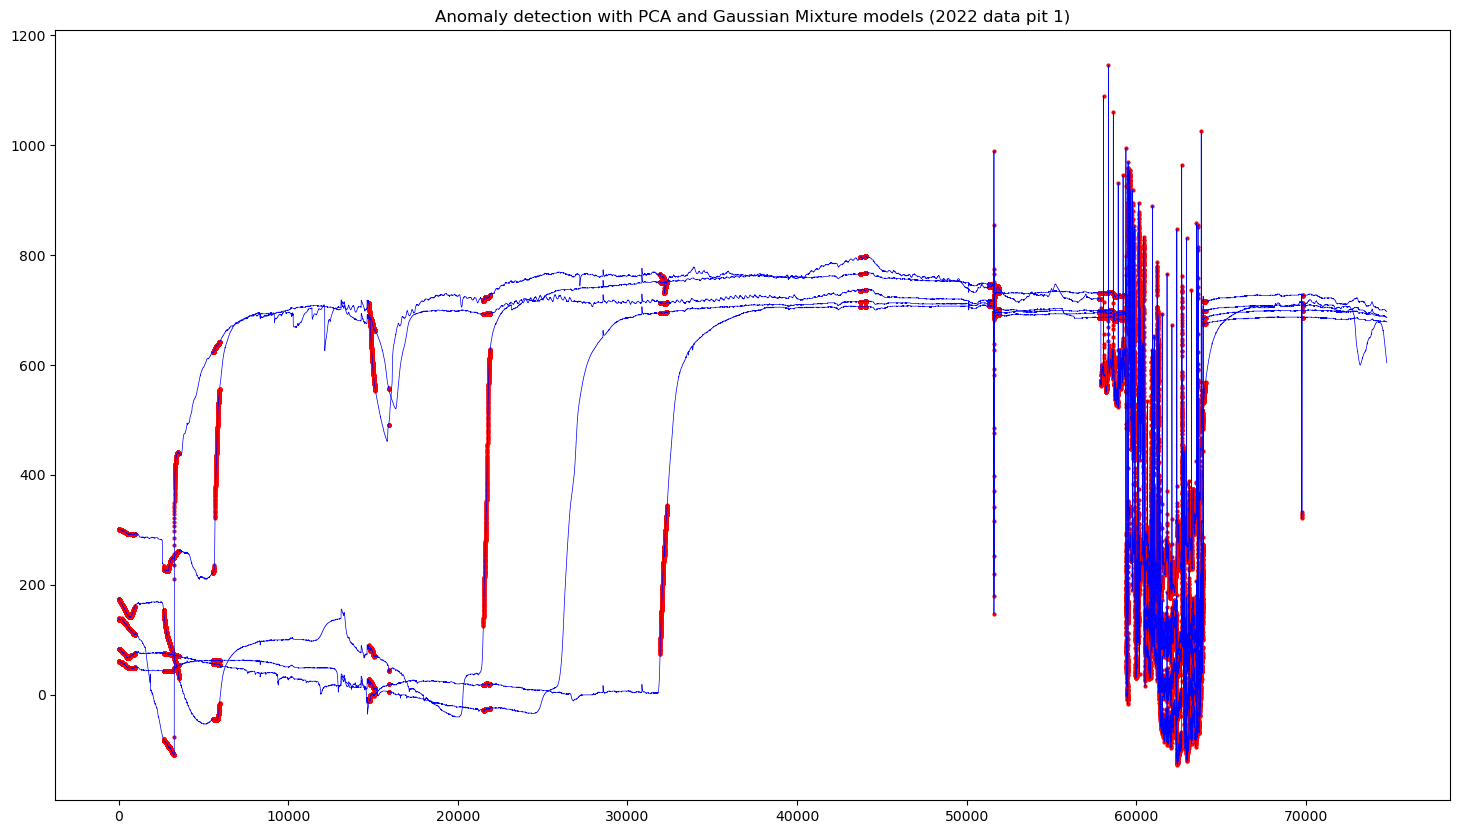

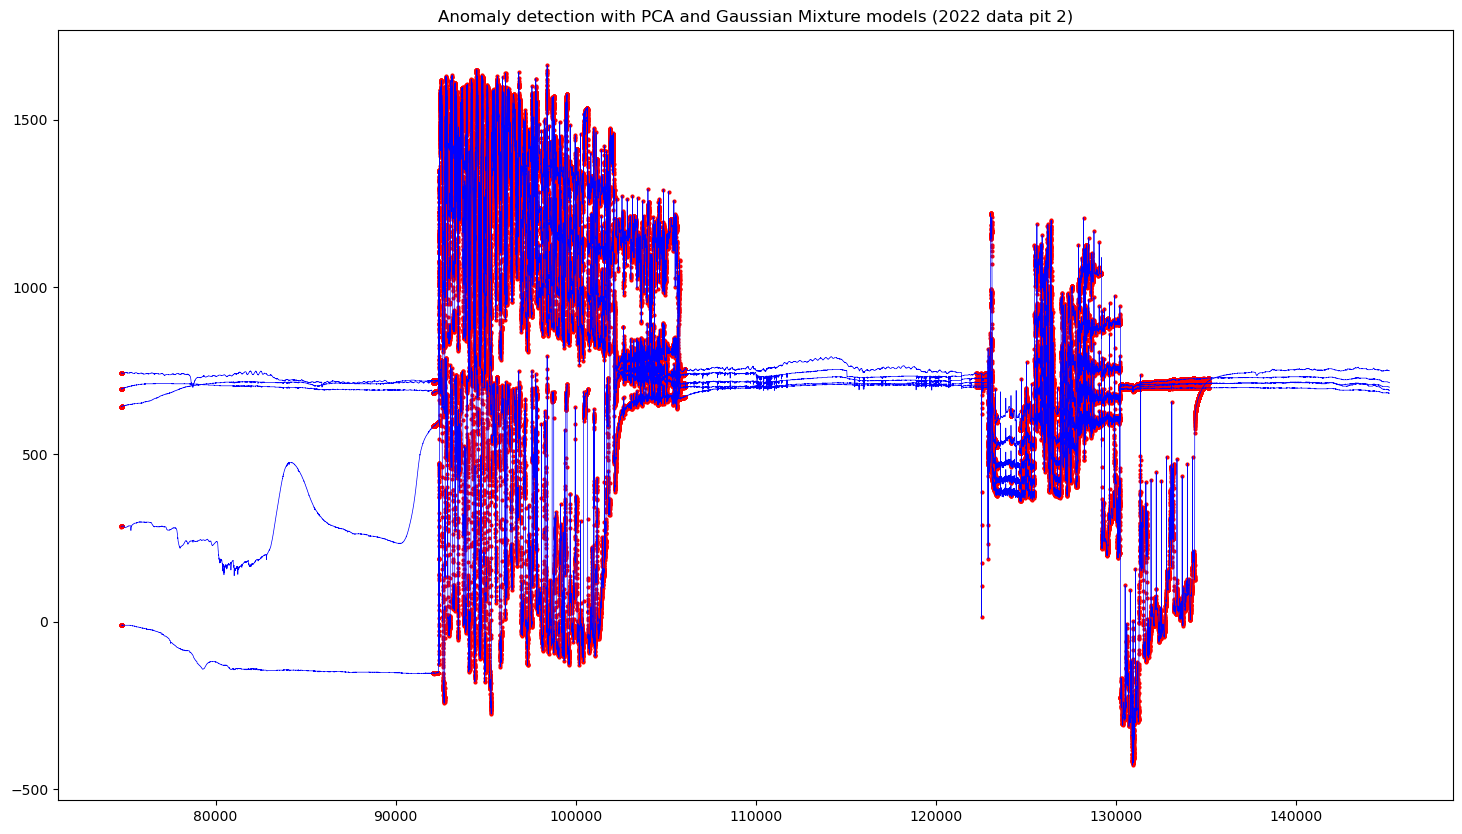

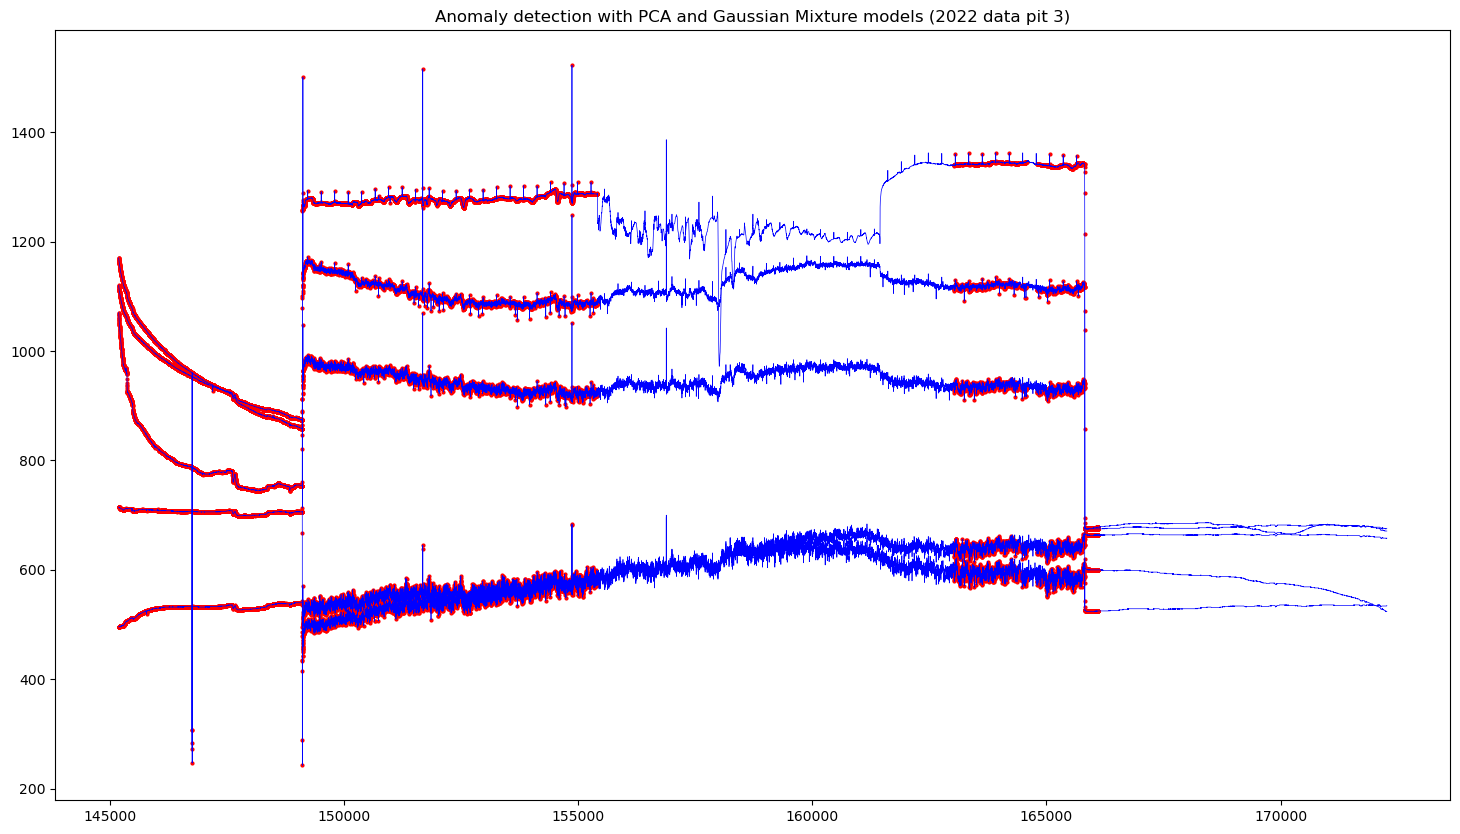

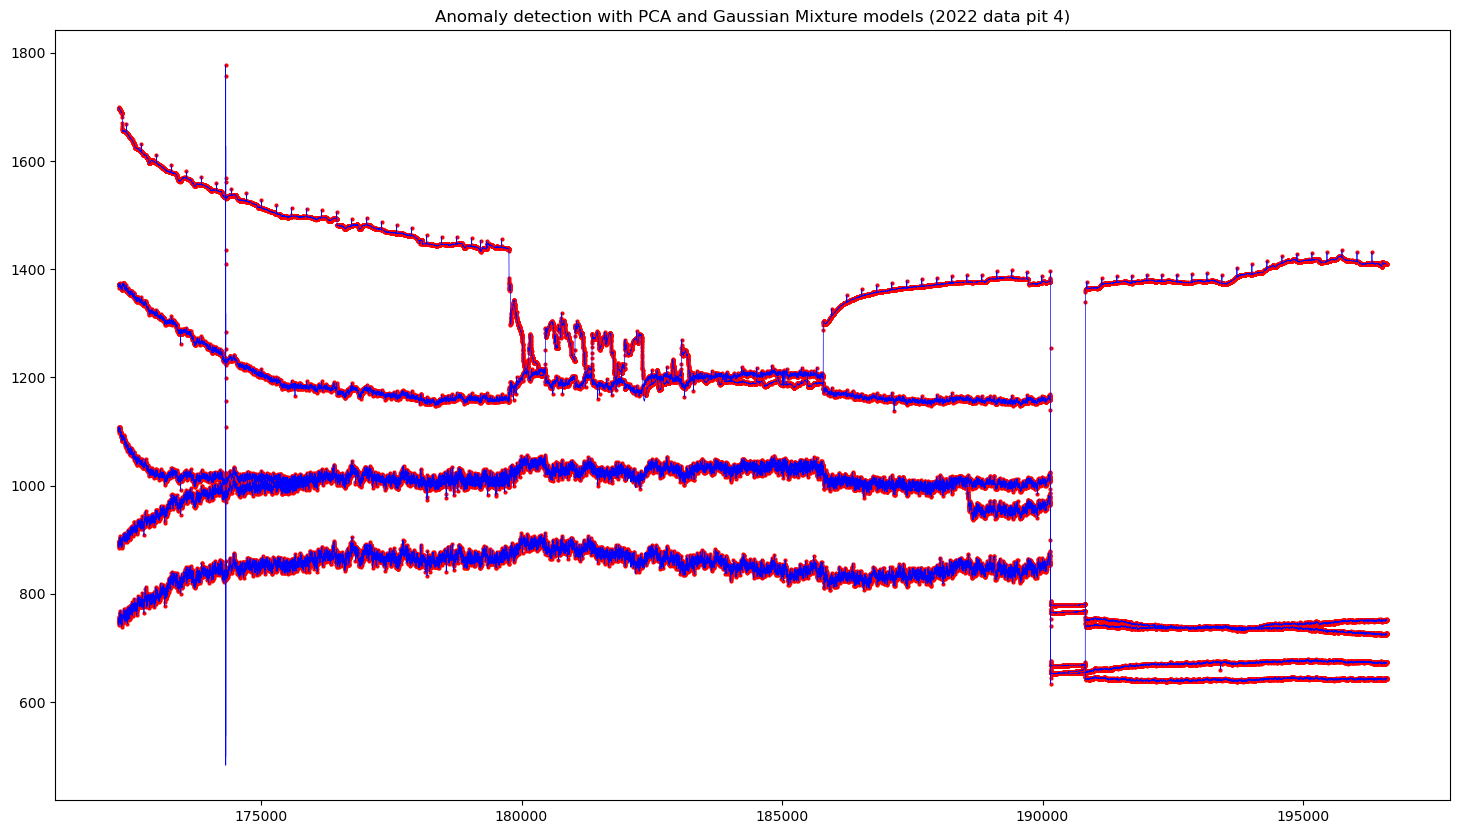

In [53]:
n_clusters = 3
pca_components = 5
outliers_fraction = 0.37
random_state = 10
pca_data = filter_pca_data(training_data_2022)

anomaly_data = pca_gmix(pca_data, training_data_2022, n_clusters, pca_components, outliers_fraction, random_state)
true_positives, true_negatives, false_positives, false_negatives = get_acc_metric_dfs(anomaly_data)
acc, prec, rec = get_acc_metrics((true_positives, true_negatives, false_positives, false_negatives))
print(f'Components: {pca_components}, clusters: {n_clusters}, acc: {acc}, precision: {prec}, recall: {rec}')

plt.figure(figsize=(18,10))
plt.plot(anomaly_data.index, anomaly_data[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5)
plt.scatter(anomaly_data[anomaly_data['anomaly'] == True].index, np.repeat(-600, anomaly_data[anomaly_data['anomaly'] == True].shape[0]), label='Detected anomalys')
plt.scatter(true_positives.index, np.repeat(-700, true_positives.shape[0]), label='True positives')
plt.scatter(false_positives.index, np.repeat(-800, false_positives.shape[0]), label='False positives')
plt.scatter(false_negatives.index, np.repeat(-900, false_negatives.shape[0]), label='False negatives')
plt.title('Anomaly detection with PCA and Gaussian Mixture models (2022 data)')
plt.legend(loc=(0.86,0.2))

for p in range(1,5):
    data = anomaly_data[anomaly_data['pit_number'] == p]
    plt.figure(figsize=(18,10))
    plt.plot(data.index, data[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5, c='blue')
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(1)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(2)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(3)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(4)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(5)'], c='red', s=4)
    plt.title(f'Anomaly detection with PCA and Gaussian Mixture models (2022 data pit {p})')

In [6]:
outliers_fraction = 0.37
pca_data = filter_pca_data(training_data_2022)

for components in range(4,8):
    for clusters in range(2,8):
        anomaly_data = pca_gmix(pca_data, training_data_2022, clusters, components, outliers_fraction, random_state=10)
        acc, prec, rec = get_acc_metrics(get_acc_metric_dfs(anomaly_data))
        print(f'Components: {components}, clusters: {clusters}, acc: {acc}, precision: {prec}, recall: {rec}')

Components: 4, clusters: 2, acc: 0.6869726207854168, precision: 0.5857859646711114, recall: 0.5756568726781492
Components: 4, clusters: 3, acc: 0.6732296080037028, precision: 0.5672142415286274, recall: 0.5574062816616008
Components: 4, clusters: 4, acc: 0.7565828624325438, precision: 0.679854285517905, recall: 0.6680986153326579
Components: 4, clusters: 5, acc: 0.7243869812673885, precision: 0.6363461406282219, recall: 0.6253427895981087
Components: 4, clusters: 6, acc: 0.6875015894491097, precision: 0.5865007904323322, recall: 0.5763593380614658
Components: 4, clusters: 7, acc: 0.7300021870819748, precision: 0.6439342910165647, recall: 0.6327997298210064
Components: 5, clusters: 2, acc: 0.7566845871755616, precision: 0.6799917520104475, recall: 0.6682337048294495
Components: 5, clusters: 3, acc: 0.9101668794409208, precision: 0.8874011959584851, recall: 0.8720567375886524
Components: 5, clusters: 4, acc: 0.8565884572934097, precision: 0.8149975943363805, recall: 0.8009050996285039
Co

## 2022 per pit

Pit: 1, components: 5, clusters: 5, acc: 0.9384496041087096, precision: 0.5960406634563938, recall: 0.7379927128188142
Pit: 2, components: 5, clusters: 5, acc: 0.7085368624332614, precision: 0.7986367509230332, recall: 0.22739770338023613
Pit: 3, components: 5, clusters: 5, acc: 0.3471468144044321, precision: 0.851865533801256, recall: 0.11776722332873704
Pit: 4, components: 5, clusters: 5, acc: 0.07254950291676937, precision: 0.7255546425636812, recall: 0.07459660386922362


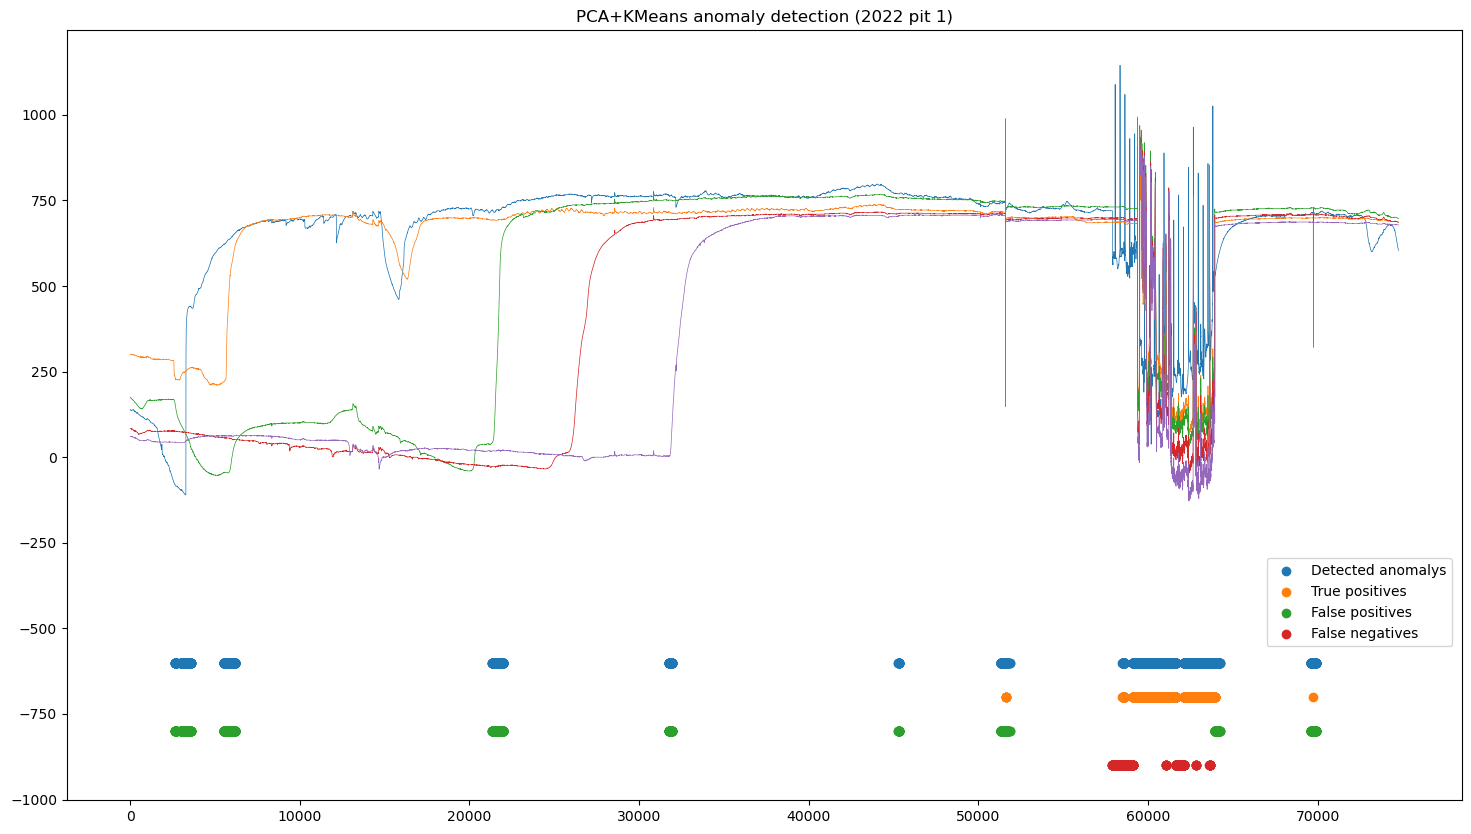

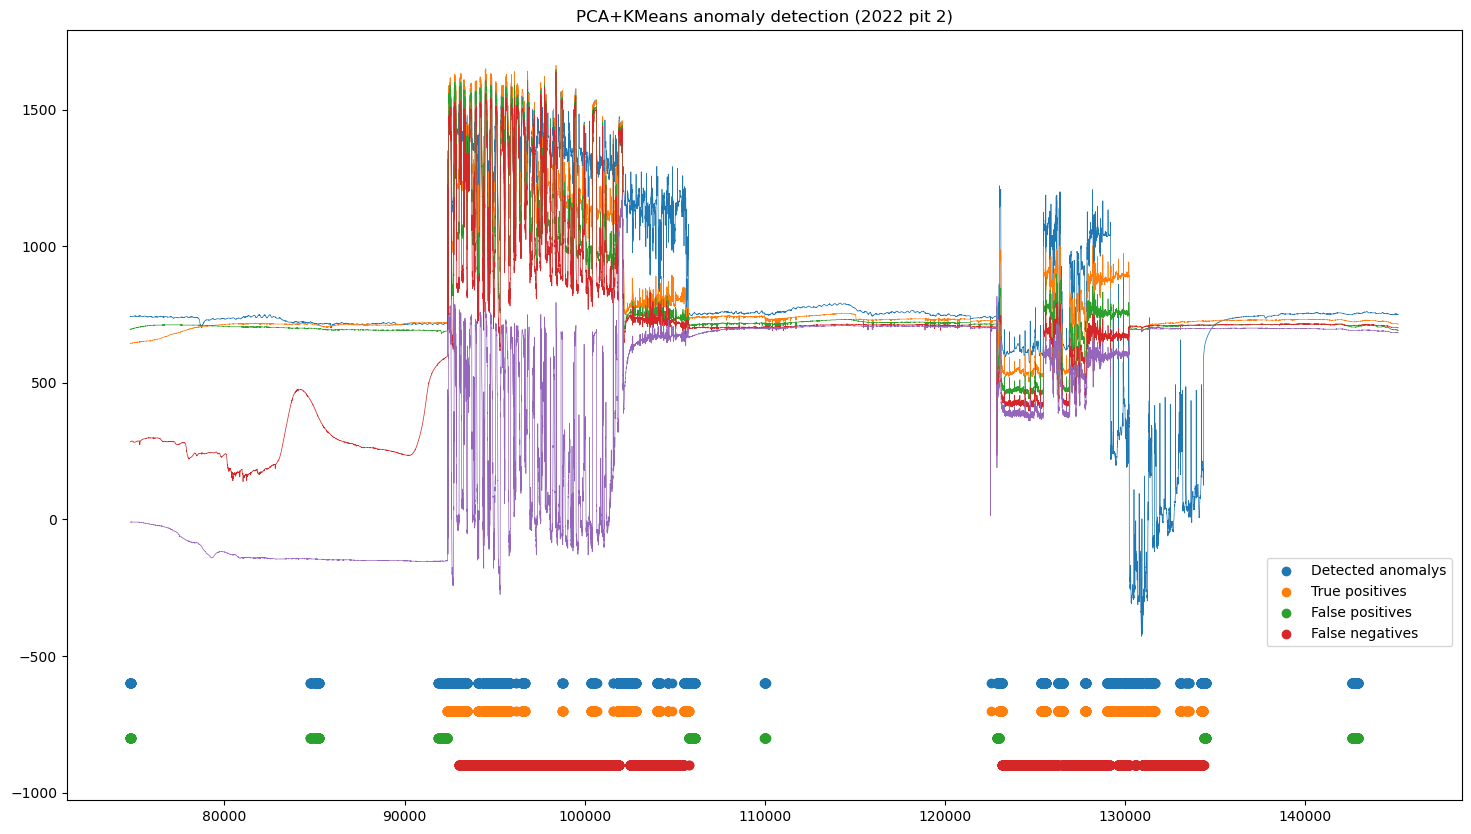

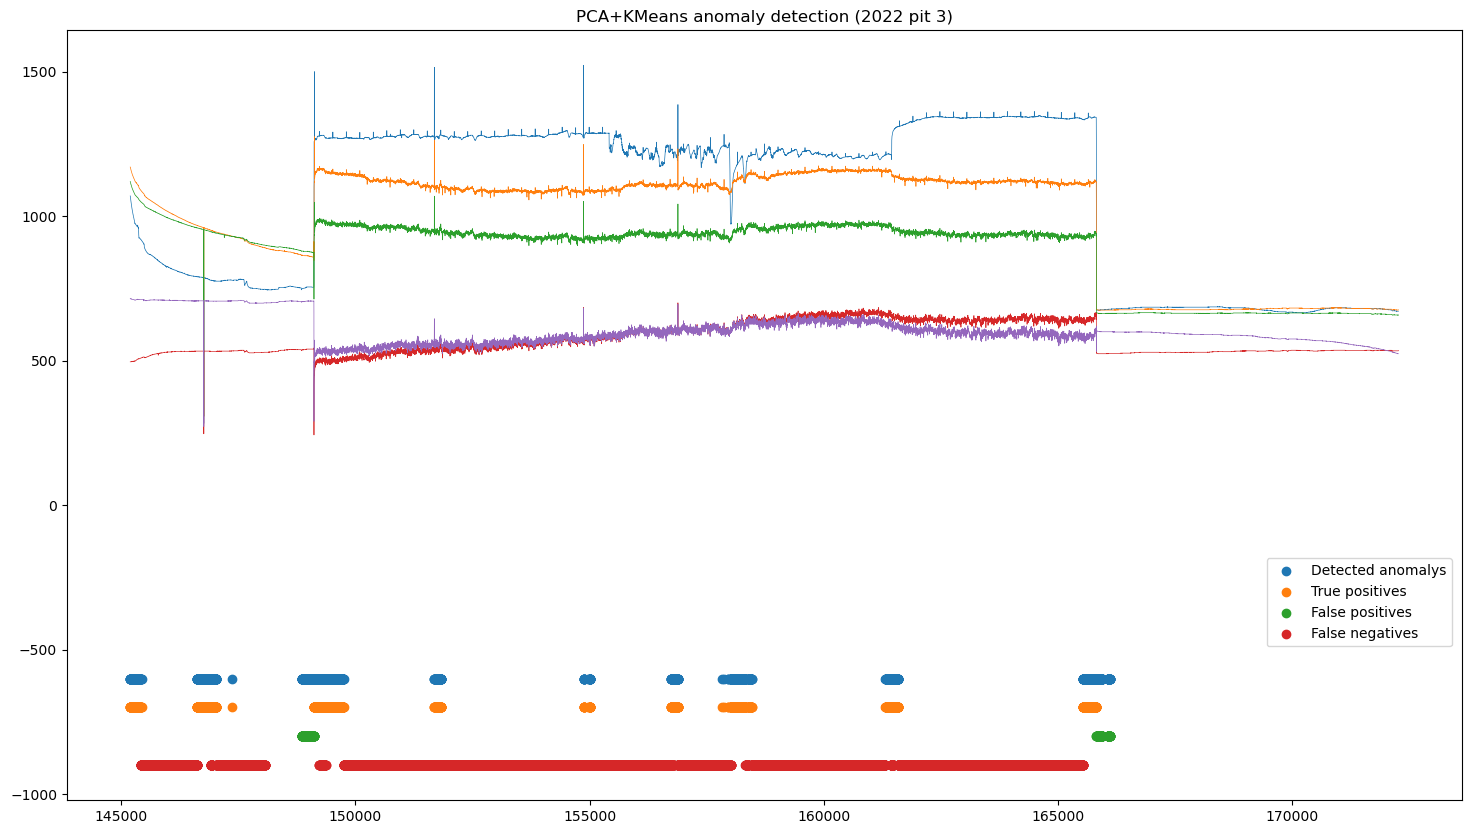

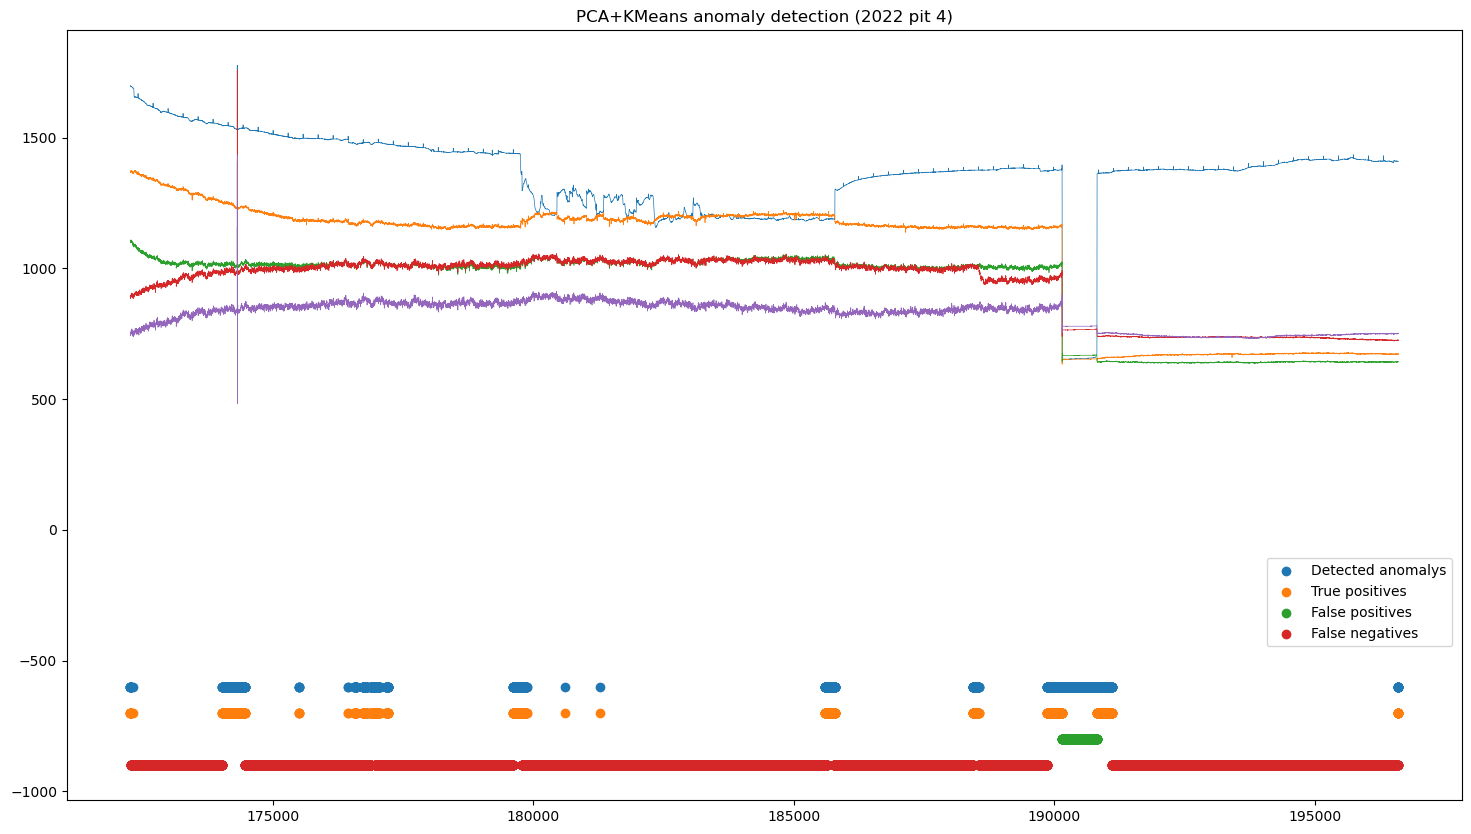

In [13]:
for pit in range(1,5):
    data = training_data_2022[training_data_2022['pit_number'] == pit]
    n_clusters = 5
    pca_components = 5
    outliers_fraction = 0.10
    pca_data = filter_pca_data(data)

    anomaly_data = pca_gmix(pca_data, data, n_clusters, pca_components, outliers_fraction, 10)
    true_positives, true_negatives, false_positives, false_negatives = get_acc_metric_dfs(anomaly_data)
    acc, prec, rec = get_acc_metrics((true_positives, true_negatives, false_positives, false_negatives))
    print(f'Pit: {pit}, components: {pca_components}, clusters: {n_clusters}, acc: {acc}, precision: {prec}, recall: {rec}')

    plt.figure(figsize=(18,10))
    plt.plot(anomaly_data.index, anomaly_data[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5)
    plt.scatter(anomaly_data[anomaly_data['anomaly'] == True].index, np.repeat(-600, anomaly_data[anomaly_data['anomaly'] == True].shape[0]), label='Detected anomalys')
    plt.scatter(true_positives.index, np.repeat(-700, true_positives.shape[0]), label='True positives')
    plt.scatter(false_positives.index, np.repeat(-800, false_positives.shape[0]), label='False positives')
    plt.scatter(false_negatives.index, np.repeat(-900, false_negatives.shape[0]), label='False negatives')
    plt.legend(loc=(0.86,0.2))
    plt.title(f'PCA+KMeans anomaly detection (2022 pit {pit})')

(0.6945409416659462, 0.7897253306205494, 0.2173048930690852)
(0.7366448128010417, 0.7188199389623601, 0.23404325792454705)
(0.7246463793620841, 0.6634282807731434, 0.21536251506695508)
(0.8043019393822256, 0.5620549338758901, 0.27006550004888064)
(0.8898270170744981, 0.5402848423194303, 0.45695848569584857)


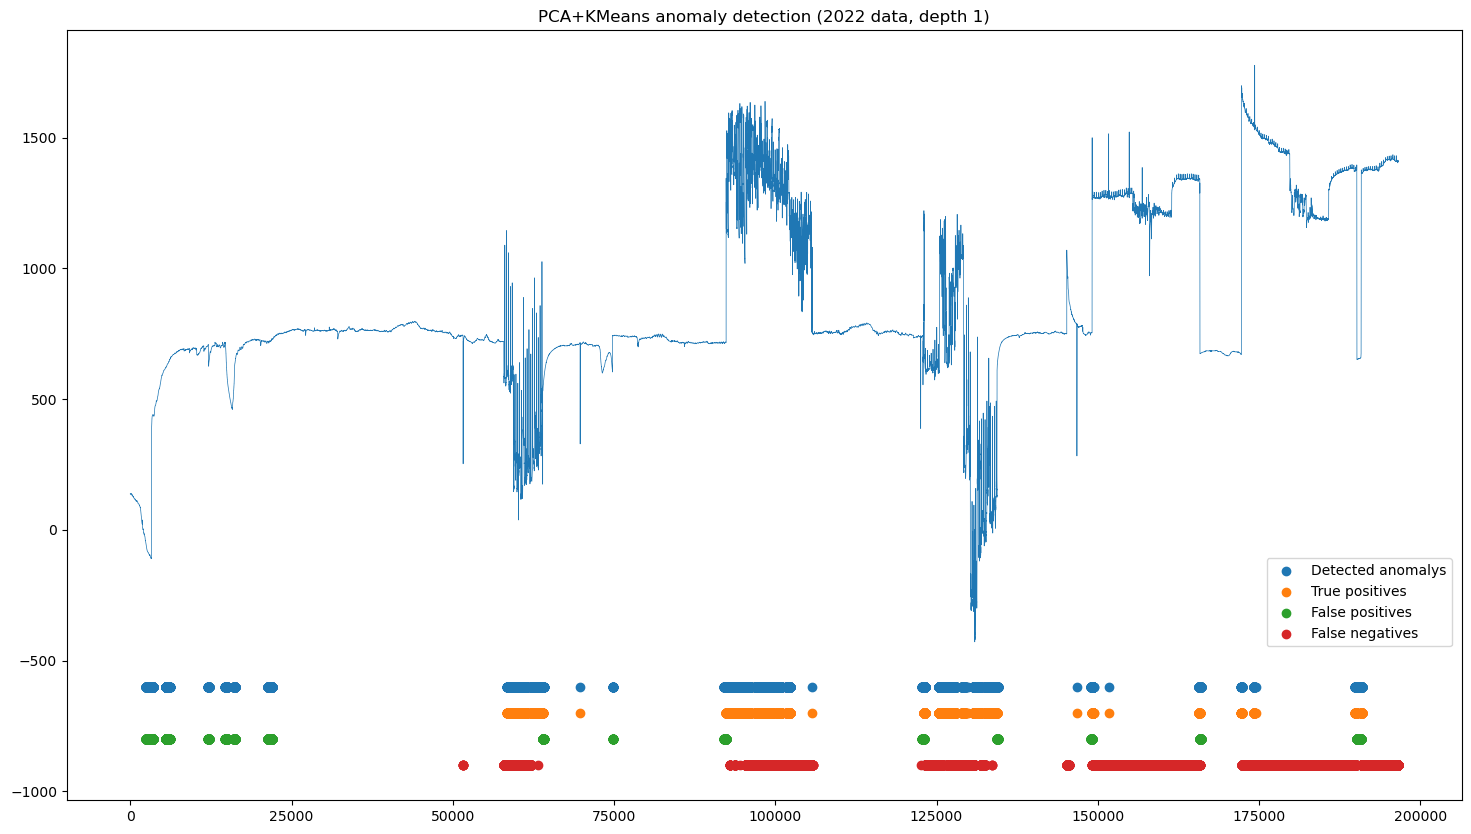

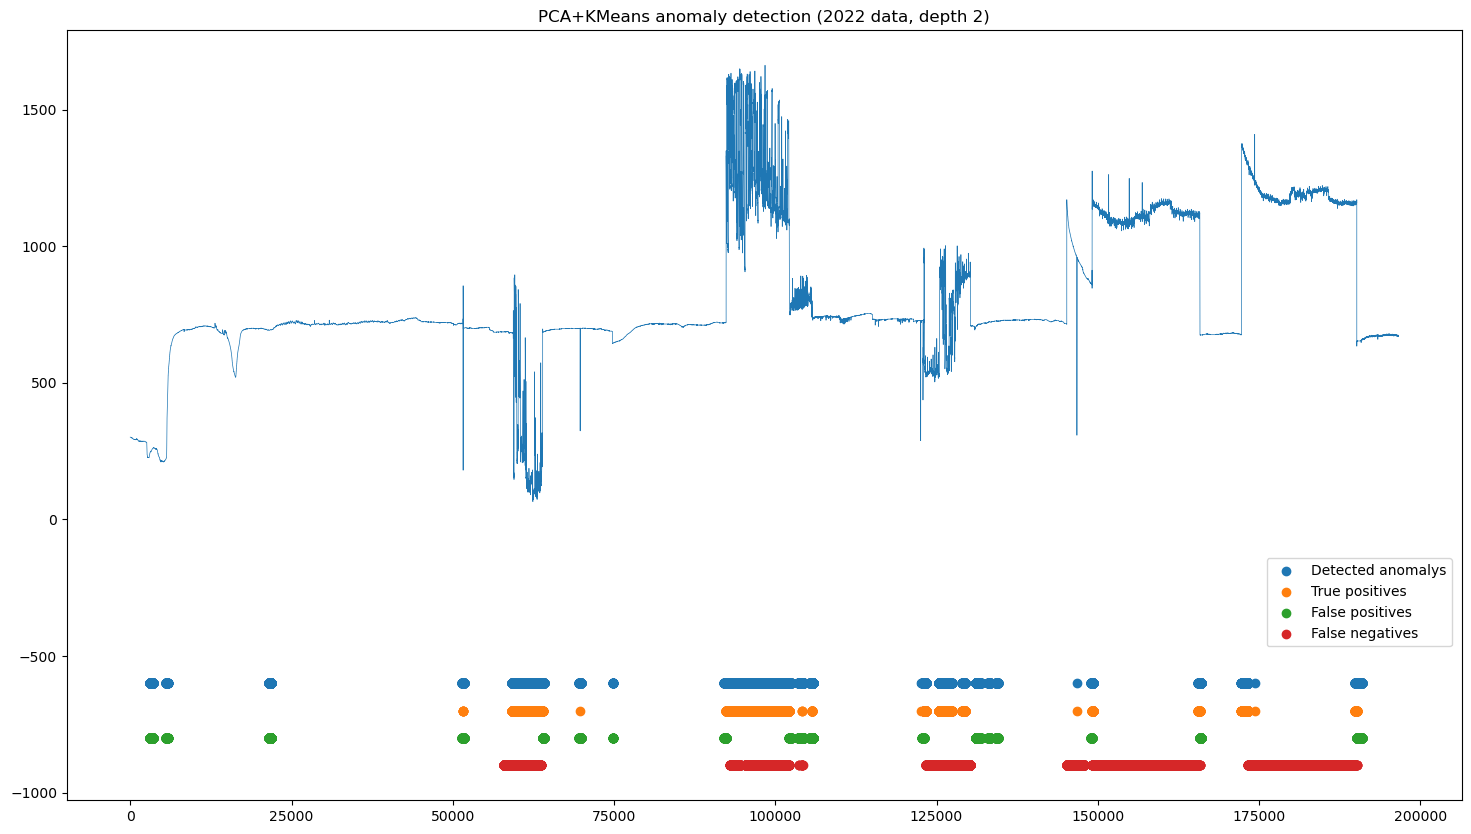

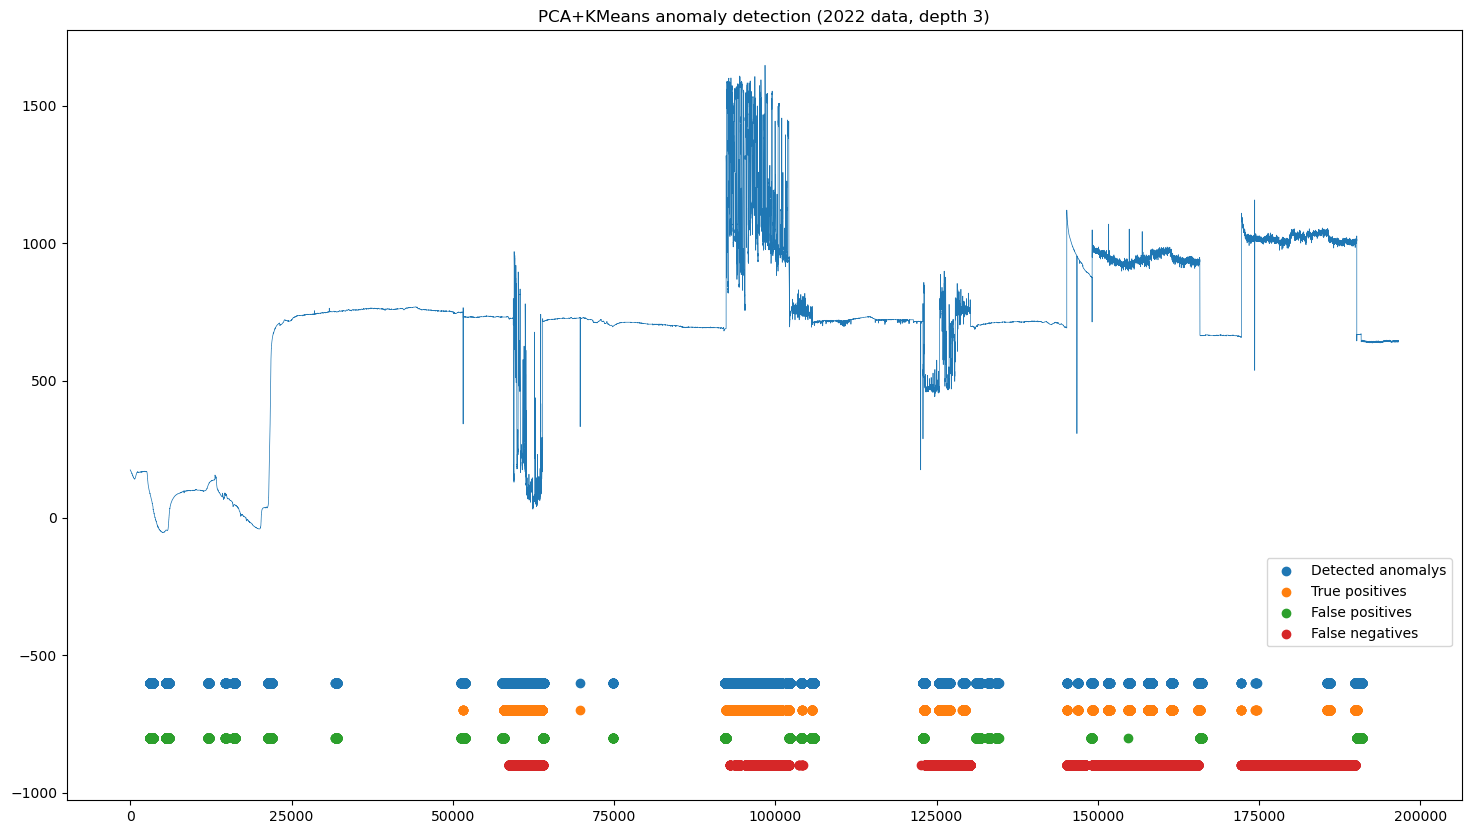

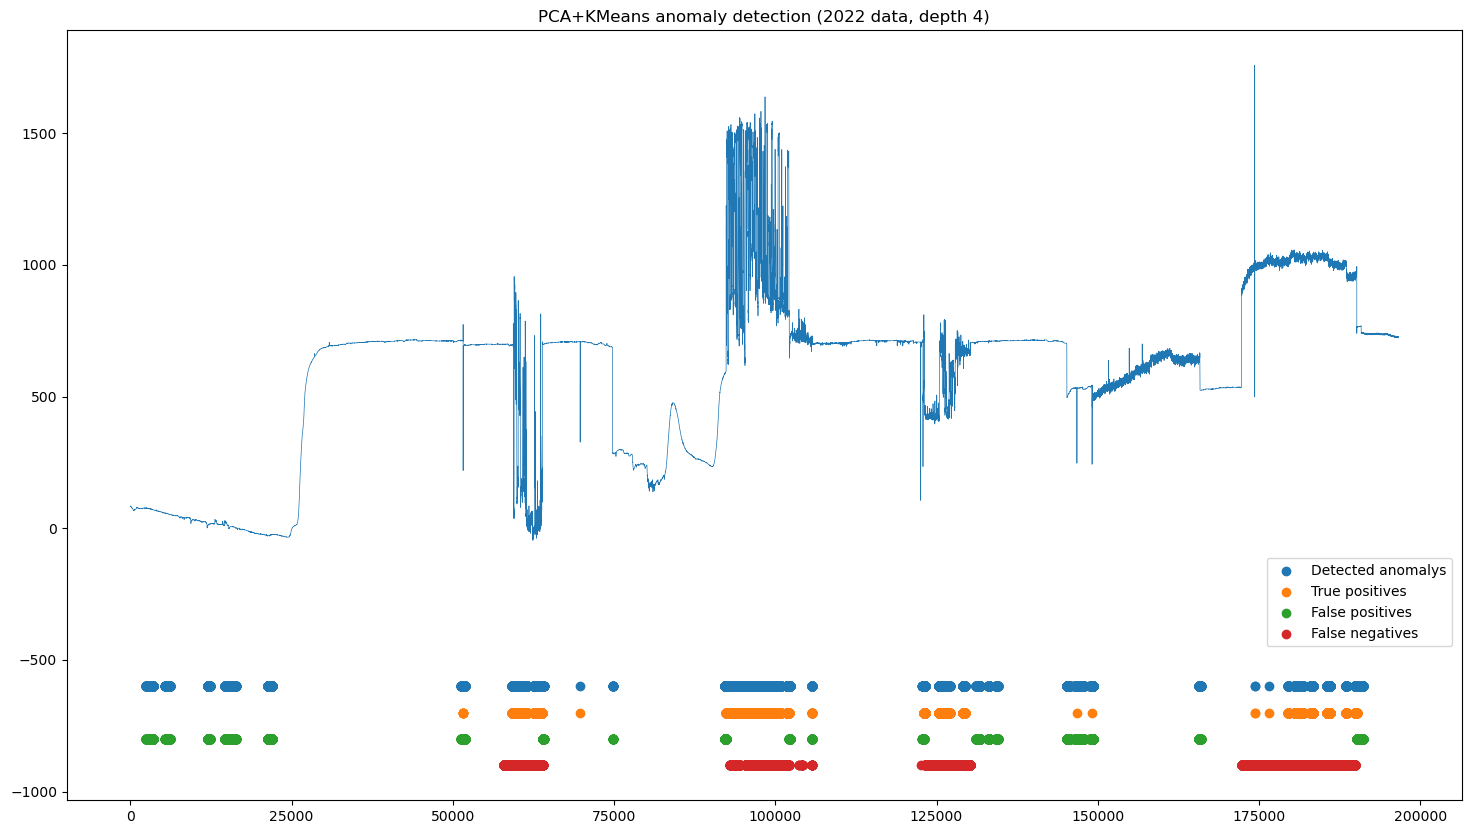

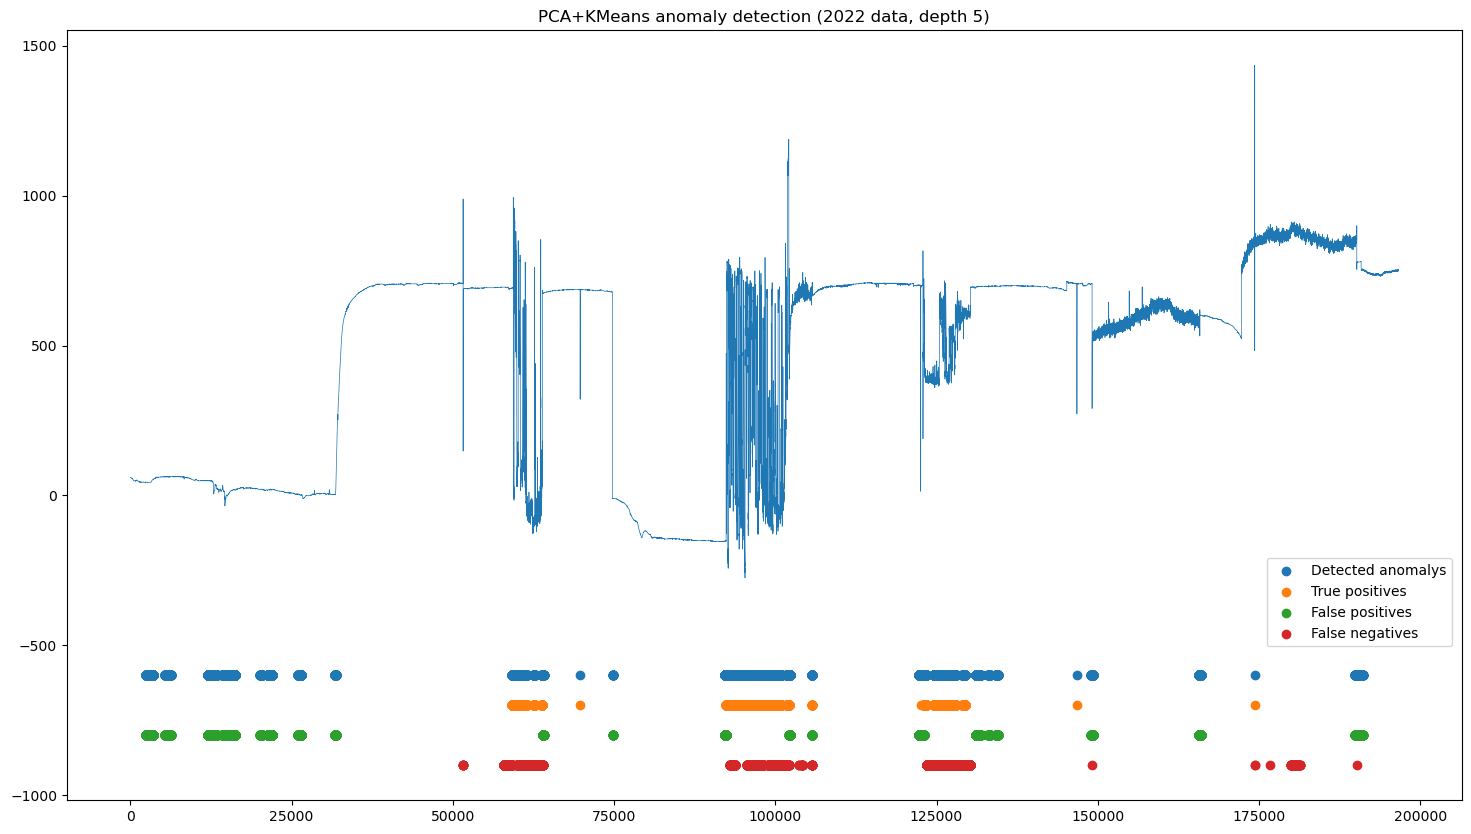

In [15]:
n_clusters = 3
pca_components = 5
outliers_fraction = 0.10
random_state = 10

for d in range(1,6):
    depths = [1,2,3,4,5]
    depths.remove(d)
    pca_data = filter_pca_data(training_data_2022, depths)

    anomaly_data = pca_gmix(pca_data, training_data_2022, n_clusters, pca_components, outliers_fraction, random_state)
    true_positives, true_negatives, false_positives, false_negatives = get_ind_depth_acc_metric_dfs(anomaly_data, d)
    print(get_acc_metrics((true_positives, true_negatives, false_positives, false_negatives)))

    plt.figure(figsize=(18,10))
    plt.plot(anomaly_data.index, anomaly_data[[f'Redox_Avg({d})']], linewidth=0.5)
    plt.scatter(anomaly_data[anomaly_data['anomaly'] == True].index, np.repeat(-600, anomaly_data[anomaly_data['anomaly'] == True].shape[0]), label='Detected anomalys')
    plt.scatter(true_positives.index, np.repeat(-700, true_positives.shape[0]), label='True positives')
    plt.scatter(false_positives.index, np.repeat(-800, false_positives.shape[0]), label='False positives')
    plt.scatter(false_negatives.index, np.repeat(-900, false_negatives.shape[0]), label='False negatives')
    plt.title(f'PCA+KMeans anomaly detection (2022 data, depth {d})')
    plt.legend(loc=(0.86,0.2))

In [16]:
n_clusters = 5
outliers_fraction = 0.10
pca_components = 6
random_state = 10

for pit in range(1,5):
   data = training_data_2022[training_data_2022['pit_number'] == pit]
   pca_data = filter_pca_data(data)
   for d in range(1,6):
      depths = [1,2,3,4,5]
      depths.remove(d)
      pca_data = filter_pca_data(data, depths)

      anomaly_data = pca_gmix(pca_data, data, n_clusters, pca_components, outliers_fraction, random_state)
      true_positives, true_negatives, false_positives, false_negatives = get_ind_depth_acc_metric_dfs(anomaly_data, d)
      acc, prec, rec = get_acc_metrics((true_positives, true_negatives, false_positives, false_negatives))
      print(f'Pit: {pit}, depth: {d}, acc: {acc}, precision: {prec}, recall: {rec}')

Pit: 1, depth: 1, acc: 0.950299593408945, precision: 0.6552969502407705, recall: 0.8113613779397152
Pit: 1, depth: 2, acc: 0.9360154076610314, precision: 0.583868378812199, recall: 0.7229214971844982
Pit: 1, depth: 3, acc: 0.9352931735501819, precision: 0.5802568218298555, recall: 0.7184498178204703
Pit: 1, depth: 4, acc: 0.9395730793922533, precision: 0.6016586409844836, recall: 0.7449486584961907
Pit: 1, depth: 5, acc: 0.9214637277979885, precision: 0.5111021936864634, recall: 0.6328254388870487
Pit: 2, depth: 1, acc: 0.7269680790639554, precision: 0.8907980687304743, recall: 0.2536390101892285
Pit: 2, depth: 2, acc: 0.8197205498125639, precision: 0.8111332007952287, recall: 0.3344653940742476
Pit: 2, depth: 3, acc: 0.8068272179938657, precision: 0.7456688440783868, recall: 0.30772386310360994
Pit: 2, depth: 4, acc: 0.8206577303192094, precision: 0.8148253337120136, recall: 0.33626347866854195
Pit: 2, depth: 5, acc: 0.7953538566397819, precision: 0.6882987787560352, recall: 0.2840482

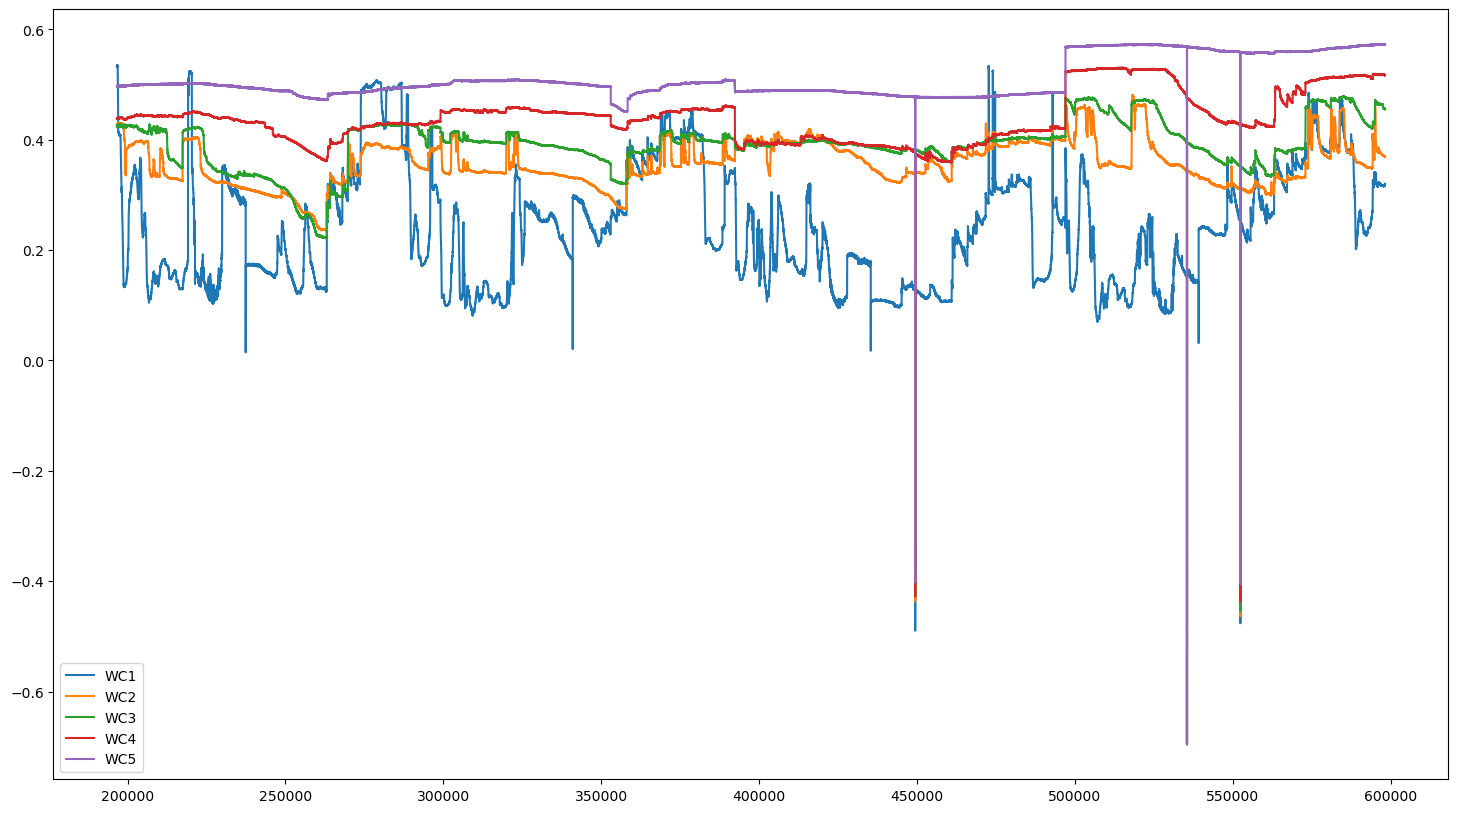

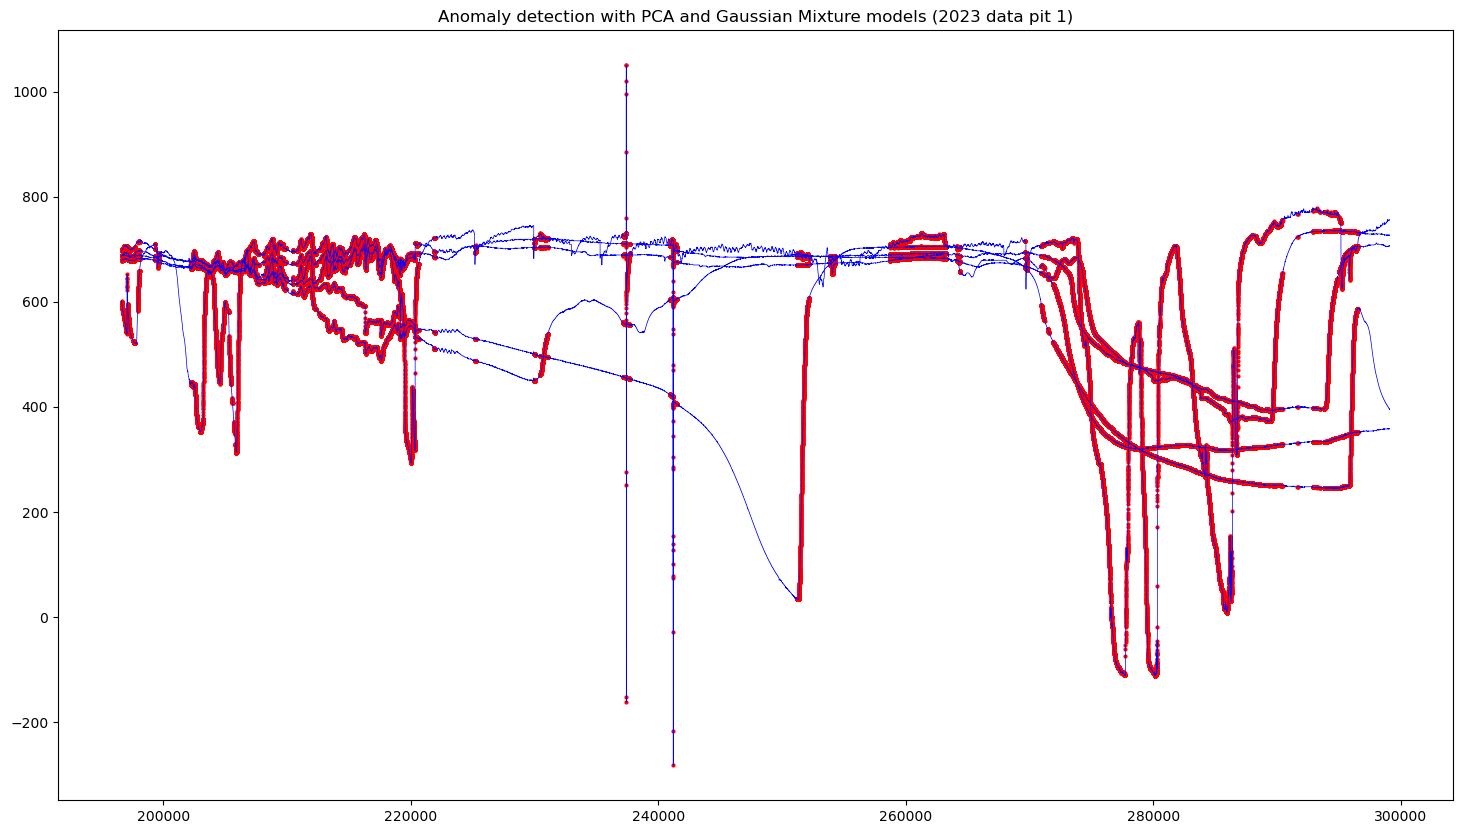

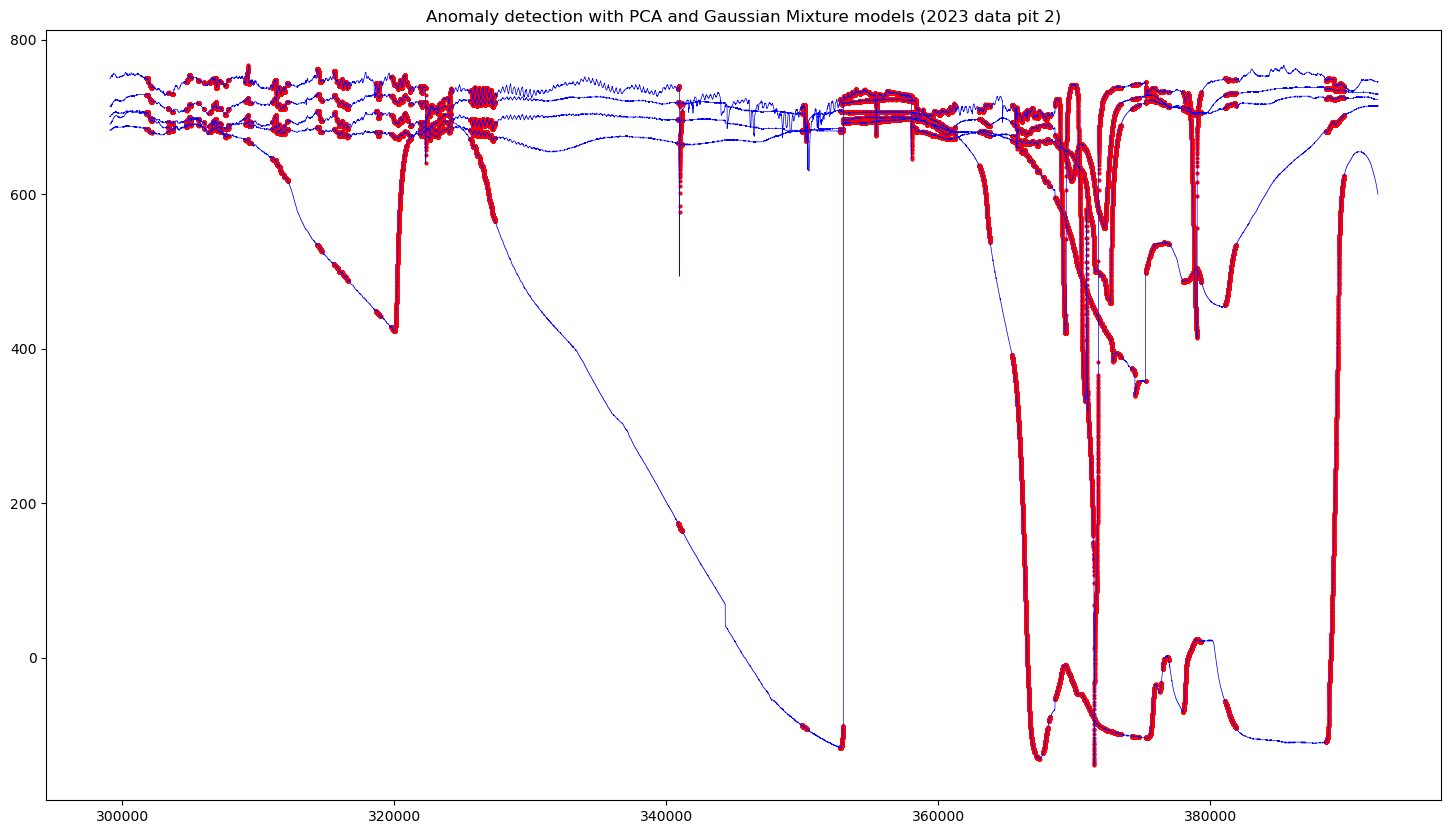

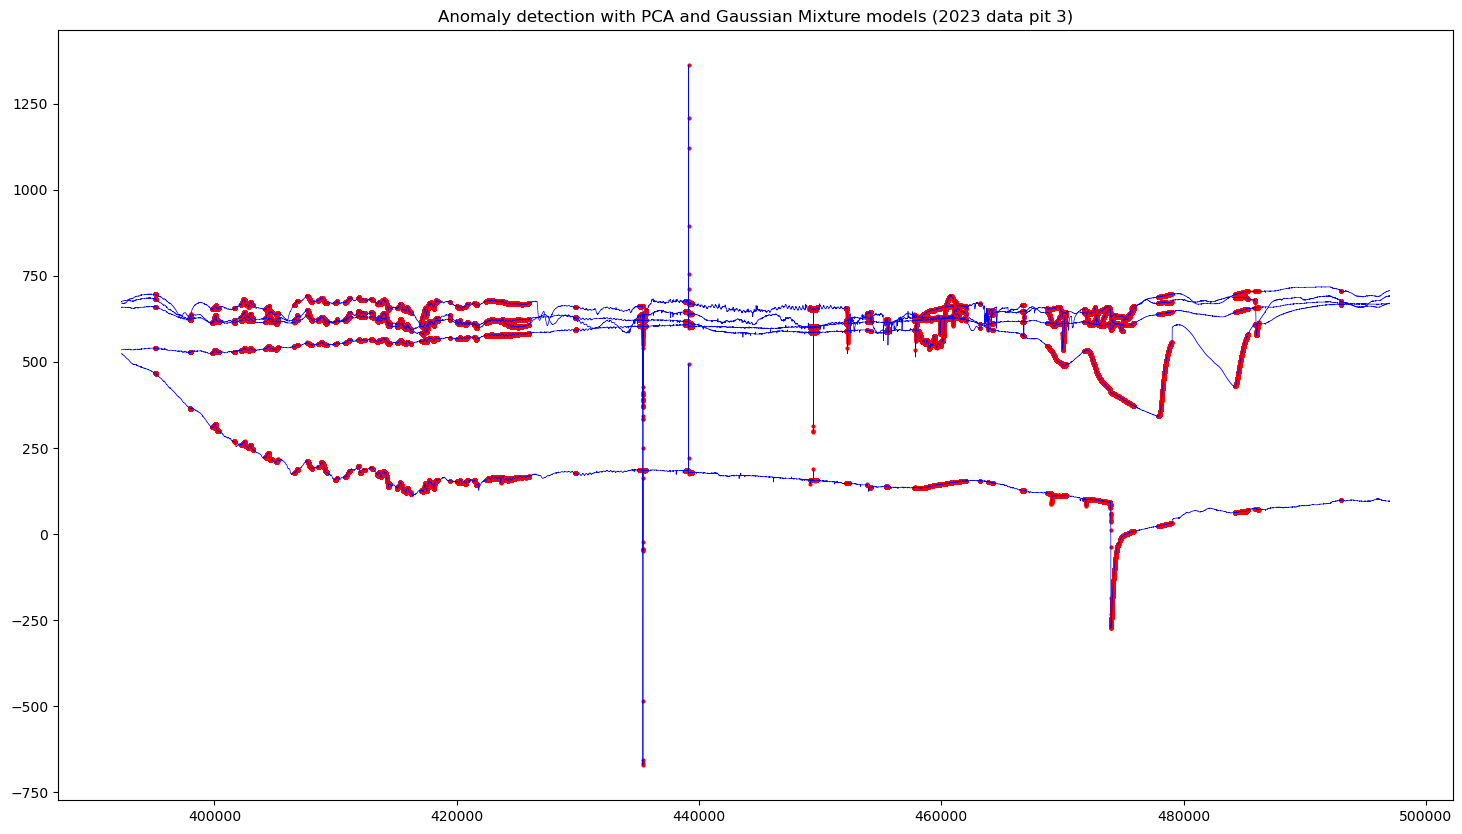

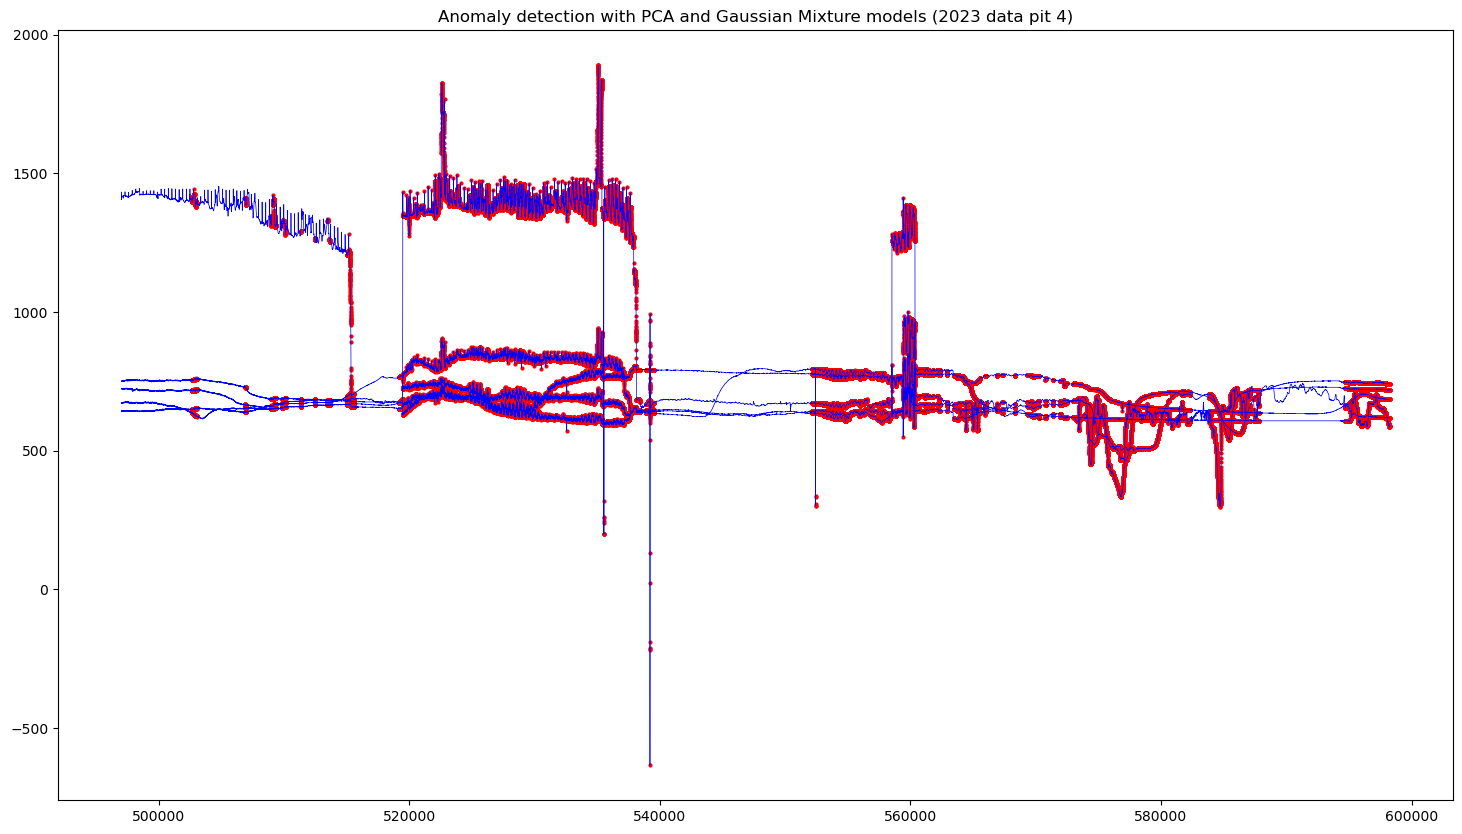

In [51]:
n_clusters = 3
pca_components = 5
outliers_fraction = 0.37
random_state = 10

pca_data = filter_pca_data(training_data_2023)
anomaly_data = pca_gmix(pca_data, training_data_2023, n_clusters, pca_components, outliers_fraction, random_state)
true_positives, true_negatives, false_positives, false_negatives = get_acc_metric_dfs(anomaly_data)

plt.figure(figsize=(18,10))
plt.plot(anomaly_data.index, anomaly_data[['WC1', 'WC2', 'WC3', 'WC4', 'WC5']], label=['WC1', 'WC2', 'WC3', 'WC4', 'WC5'])
plt.legend()

for p in range(1,5):
    data = anomaly_data[anomaly_data['pit_number'] == p]
    plt.figure(figsize=(18,10))
    plt.plot(data.index, data[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5, c='blue')
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(1)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(2)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(3)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(4)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(5)'], c='red', s=4)
    plt.title(f'Anomaly detection with PCA and Gaussian Mixture models (2023 data pit {p})')